Universidad Galileo

Text Mining and Image Recognition

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Proyecto Final

Este proyecto consiste en la elaboración de un pipeline de transformaciones que permita estimar el número de hojas en una área determinada cubierta por grama. Para este proyecto se utilizan librerias de Computer Vision para hacer las transformaciones correspondientes y el cálculo de la estimación.

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Imagen Original

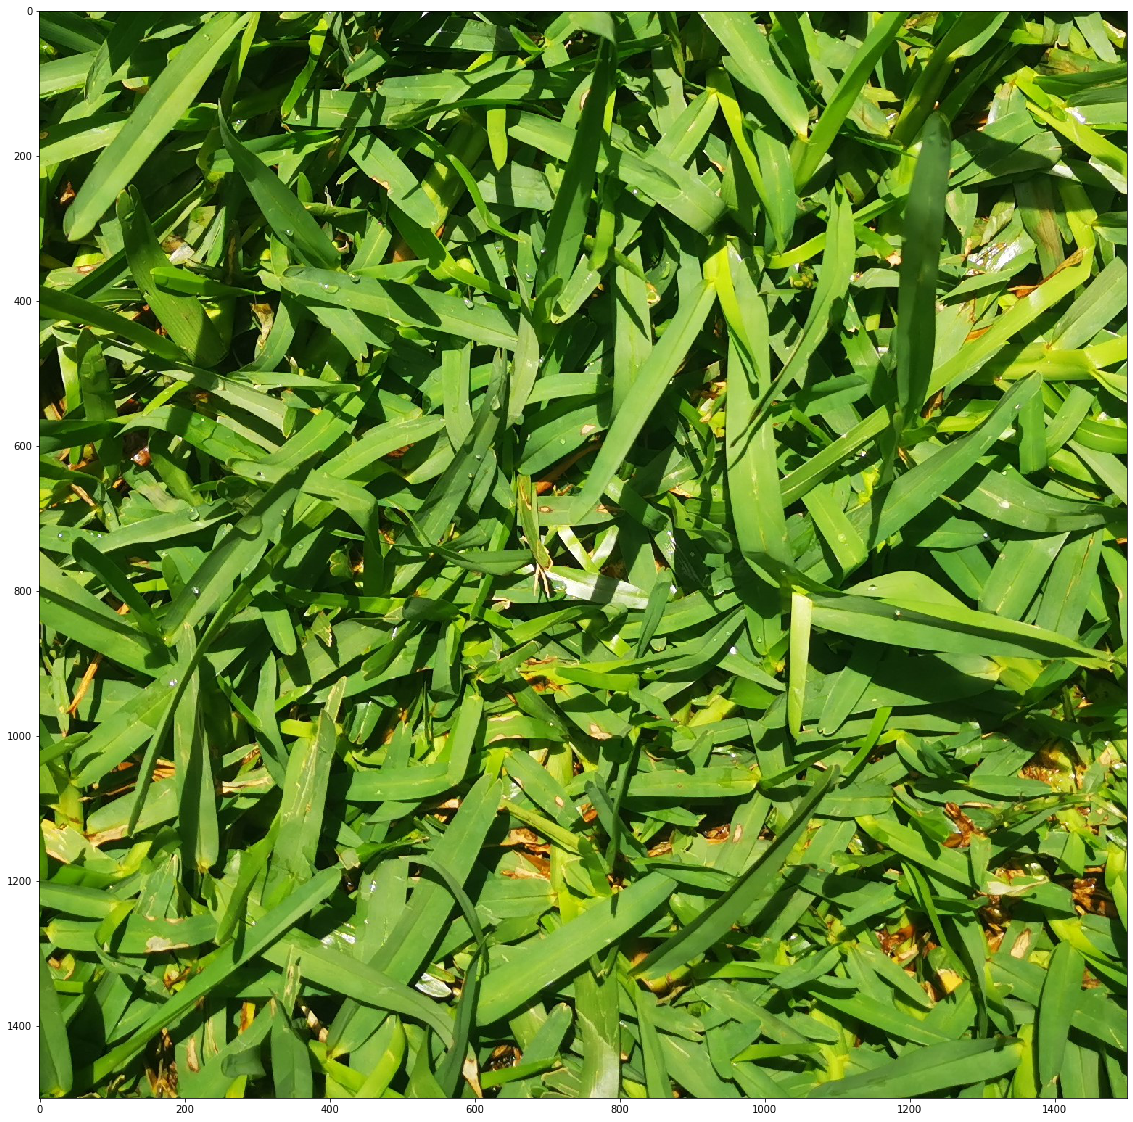

In [20]:
path ="./imagenes/grama1copia.jpg"
image = cv2.imread(path)
image = cv2.resize(image,(1500,1500))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,20))
plt.imshow(image)

En la práctica se observa que las hojas pueden estar apiladas unas sobre otras, y también que existe otro tipo de vegetacio´n que no es precisamente grama que interfiere en el conteo. Por este motivo se propone un enfoque de "muestreo" en cuadros de imagen más reducidos, que permitan reducir el problema del apilamiento y distinguir con alguna metodología entre hojas de grama y otro tipo de vegetación.

### Segmentación de Imagen en Sub Imágenes

Como paso inicial se propone la separación de imágenes en cuadros más pequeños. Se implementa una función para la "separación" de cuadros, con ancho y alto como parámetros.

In [21]:
def separacion_imagenes(im, ancho, alto):
    
    w, h = im.size

    w_step = w / ancho
    h_step = h / alto

    cuadros = []
    for y in range(0, alto):
        for x in range(0, ancho):
            x1 = x * w_step
            y1 = y * h_step
            x2 = x1 + w_step
            y2 = y1 + h_step
            t = im.crop((x1, y1, x2, y2))
            cuadros.append(t)

    return cuadros

In [22]:
numero_particiones = 16 # Número con raíz cuadrada exacta
filas = columnas = int(np.sqrt(numero_particiones))

pictures = Image.open('./imagenes/grama1copia.jpg') 
porciones = separacion_imagenes(pictures,filas,columnas)

particiones = []
for porcion in porciones:
    particiones.append(np.asarray(porcion))

### Grid de Cuadros a Muestrear

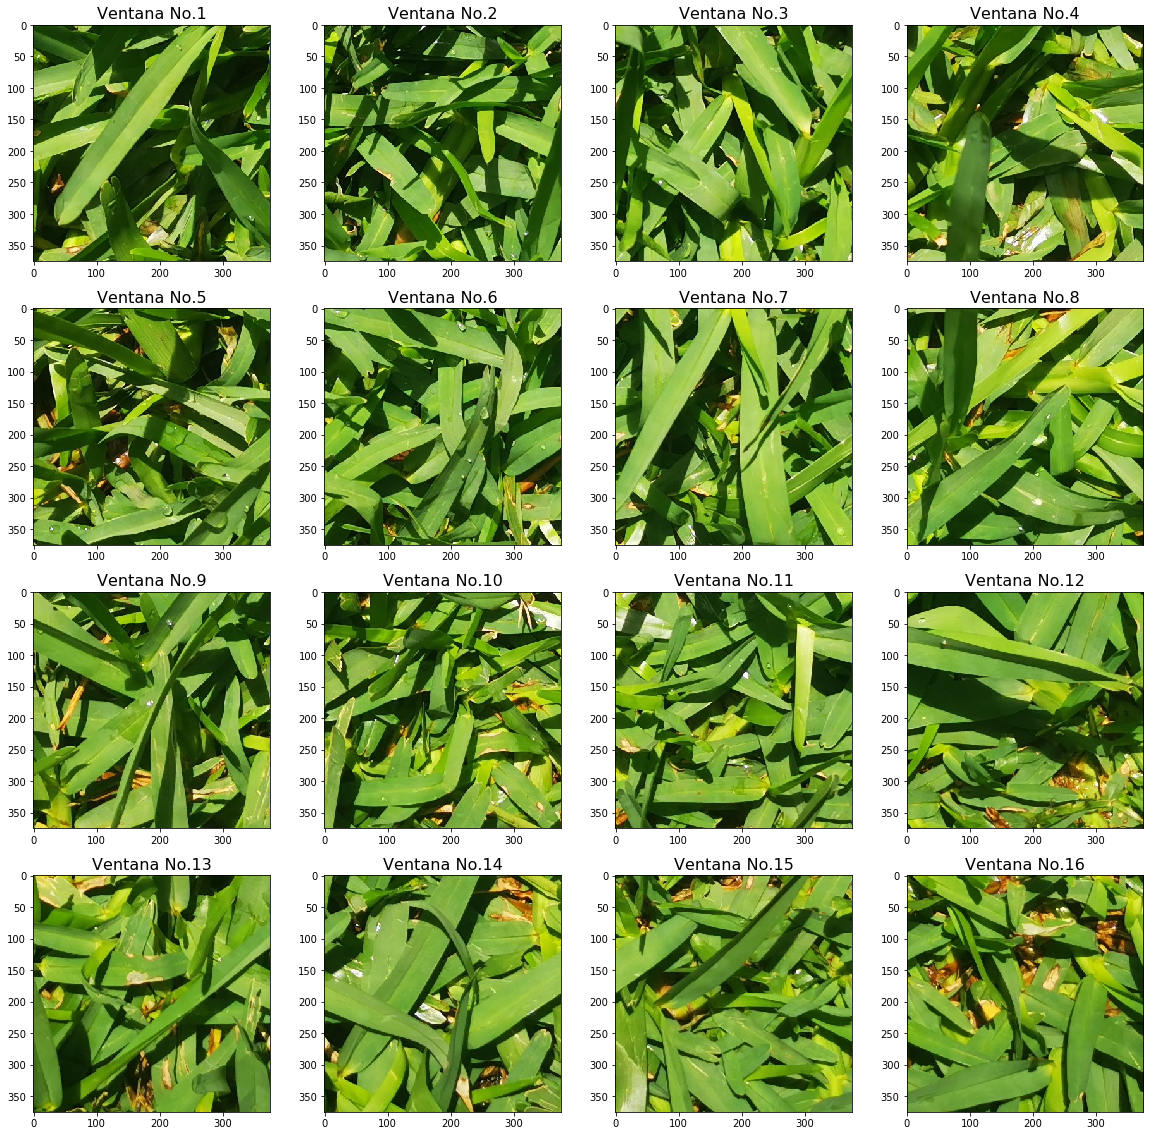

In [23]:
plt.figure(figsize=(20,20))

for indice in range(numero_particiones):
    plt.subplot(filas,columnas,indice+1)
    plt.title('Ventana No.'+str(indice+1), fontsize=16)
    plt.imshow(particiones[indice])

### Escala de Grises Ponderada
La primera transformación propuesta es pasar a una escala de grises, que mejore la visibilidad sobre el color verde de las hojas. En este caso, aumentando el segundo canal.

In [24]:
def escala_grises_ponderada(imagen_entrada):
    
    image = imagen_entrada.copy()
    ancho = image.shape[0]
    alto = image.shape[1]

    gris_ponderado = np.zeros((ancho,alto,1),dtype=np.int32)

    for i in range(0,ancho):
        for j in range(0,alto):
            pixel = image[i,j] # RGB
            promedio_ponderado = (int(0.299*pixel[0])+int(0.587*pixel[1])+int(0.114*pixel[2]))
            gris_ponderado[i,j] = int(promedio_ponderado)
    
    # Ensamble de Imágenes en Escala de Grises
    escala_gris_ponderado = np.concatenate((gris_ponderado,gris_ponderado,gris_ponderado),axis=2)
     
    return escala_gris_ponderado
    

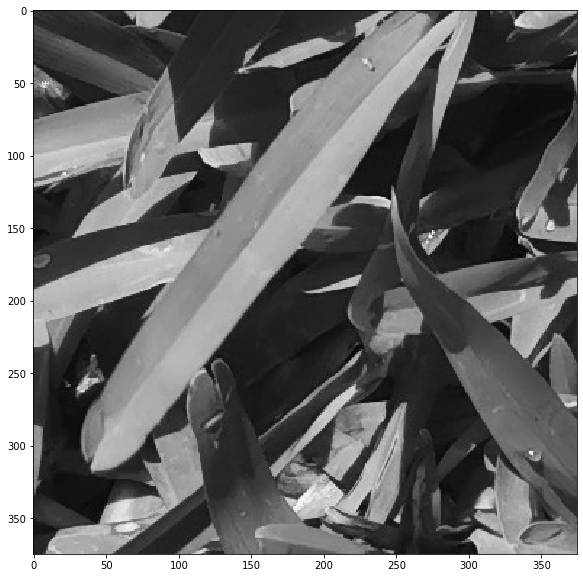

In [25]:
gris_ponderado=escala_grises_ponderada(particiones[0])
plt.figure(figsize = (10,10))
plt.imshow(gris_ponderado)

### Equalización
Se aplica esta transformación para mejorar el contraste de la imagen.

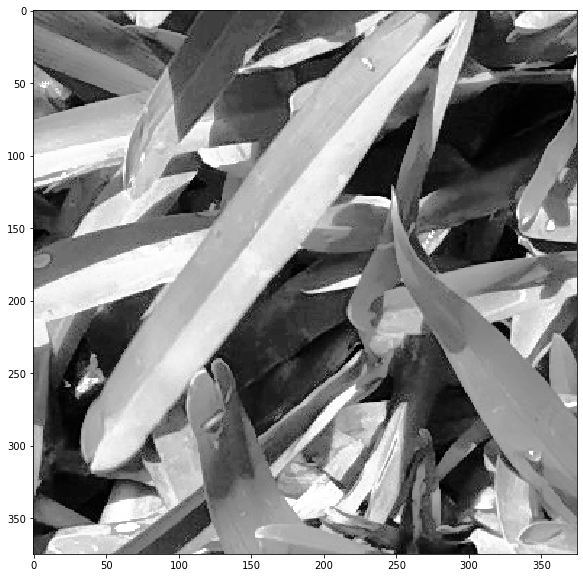

In [26]:
gris_ponderado_uint8 = np.uint8(gris_ponderado)
grayimg = cv2.cvtColor(gris_ponderado_uint8, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(equ,cv2.COLOR_BGR2RGB))

## Detección de Bordes
Para esta transformación se elige el algoritmo de Canny, con umbral [100,200]

### Canny

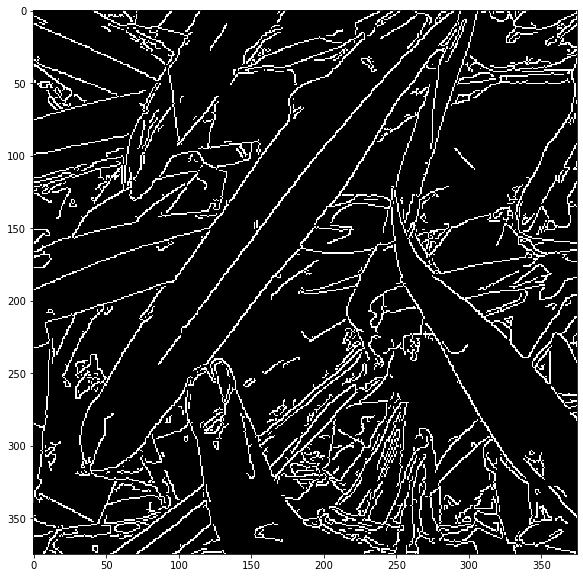

In [27]:
equ_uint8 = np.uint8(equ)
canny_image = cv2.Canny(equ_uint8,100,200)

plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(canny_image,cv2.COLOR_BGR2RGB))

### Binarización
Para facilitar la tarea del algoritmo de detección de lineas por medio de la transformación de Hough se realiza una binarización.
Se experimentó utilizando una binarización adaptativa con el algoritmo de **Otsu** en el que el valor ideal del umbral (comúnmente fijado en 127) es encontrado automáticamente con la distribución de frecuencias de los pixeles.

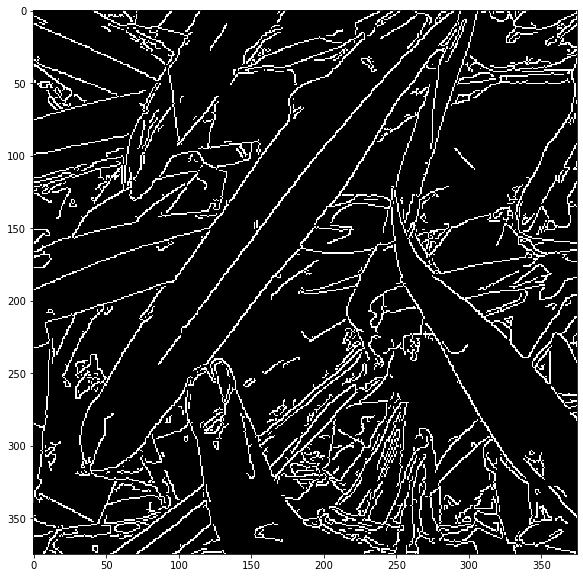

In [28]:
ret,imagen_binarizada = cv2.threshold(canny_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(imagen_binarizada,cv2.COLOR_BGR2RGB))

Puede observarse que existe un problema significativo al tener áreas donde la vegetación es densa y pequeña. Esto supone un problema para cualquier algoritmo que intente encontrar lineas rectas de las hojas, pues aparecen estas regiones densas que provocarían falsos bordes, complicando la contabilización de las hojas.

Para resolver este problema se propone un enfoque particular utilizando los contornos, el cual se muestra a continuación:

### Cálculo de Contornos

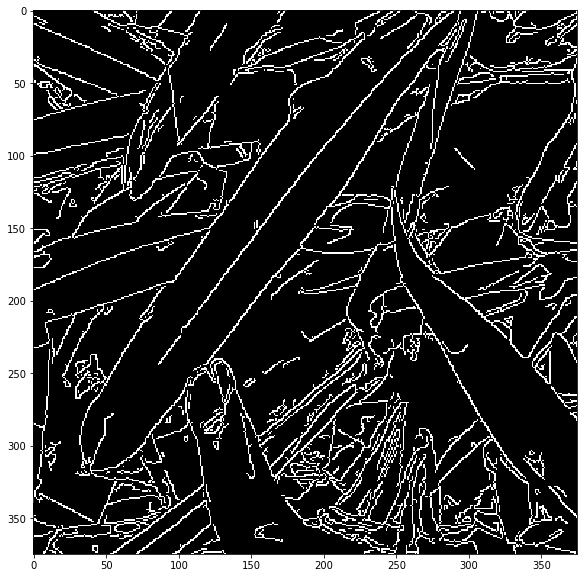

In [29]:
## Añadir Contornos a Imagen
contours, hierarchy = cv2.findContours(imagen_binarizada,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

fondo_contorno = np.zeros(imagen_binarizada.shape,np.uint8)
contornos = cv2.drawContours(fondo_contorno, contours, -1, (255,255,255), 1)
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(contornos,cv2.COLOR_BGR2RGB))

Puede observarse que existen pequeños contornos correspondientes a la diversa y pequeña vegetación alrededor de las hojas. Estas áreas son notables pues contienen una mayor densidad de pixeles blancos, pero además, se caracterízan por tener "contornos pequeños" comparados con los contornos de las hojas. Se propone entonces un método para remover de la imagen lás áreas con contornos pequeños por medio de la construcción de una máscara, que oculte o elimine las áreas donde se concentran los contornos pequeños.

Para poder encontrar los contornos pequeños, se utiliza la función **contourArea** y se filtra para valores pequeños. La máscara solamente contendrá los contornos pequeños:

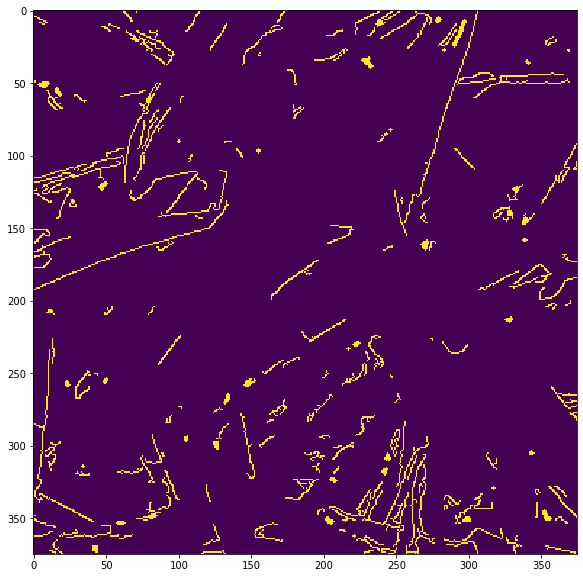

In [30]:
fondo_contornos_pequenos = np.zeros(imagen_binarizada.shape,np.uint8)
for cnt in contours:
    if 0<cv2.contourArea(cnt)<25:
#        cv2.drawContours(img,[cnt],0,(0,255,0),2)
        mascara = cv2.drawContours(fondo_contornos_pequenos,[cnt],0,255,-1)

#ret,mascara = cv2.threshold(mascara,127,255,0)
plt.figure(figsize = (10,10))
plt.imshow(mascara)

Finalmente se aplica la máscara a la imagen binarizada, para **eliminar las áreas irregulares** y faciliten la tarea de la Transformación de Houg

Text(0.5, 1.0, 'Imagen Limpia')

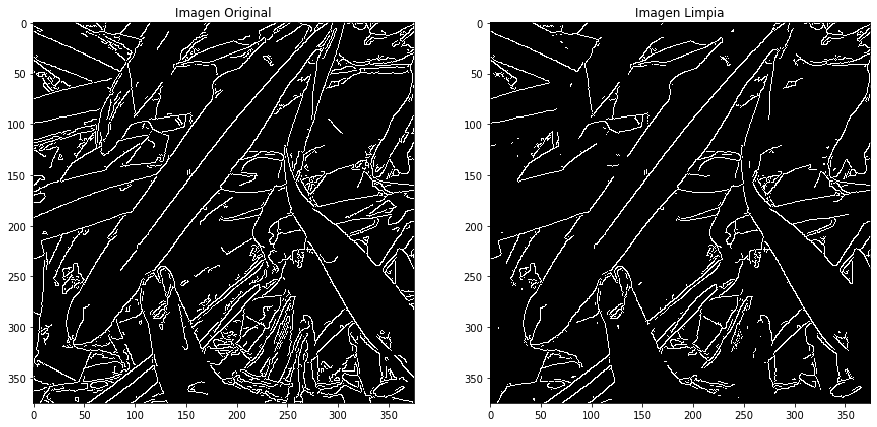

In [48]:
imagen_filtrada = imagen_binarizada.copy()
cv2.bitwise_not(imagen_filtrada,imagen_filtrada,mascara)



fig, ax = plt.subplots(1, 2,figsize=(15,15))
ax[0].imshow(cv2.cvtColor(imagen_binarizada,cv2.COLOR_BGR2RGB))
ax[0].set_title("Imagen Original")
ax[1].imshow(cv2.cvtColor(imagen_filtrada,cv2.COLOR_BGR2RGB))
ax[1].set_title("Imagen Limpia")

## Transformación de Hough

Teniendo la imagen de los bordes lo más limpia posible, se procede a aplicar la Transformación de Hough con el objetivo de poder encontrar rectas en la imagen. Debido a la naturaleza "ruidosa" de la imagen, se decide utilizar una Transformación de Hough probabilística, en la que se puede parametrizar la distancia máxima entre puntos (para ser considerados de la misma linea), la longitud mínima de linea y la votación mayoritaria mínima para que una linea sea considerada como tal.

La función se denomina **HoughLinesP** y se realizaron varios experimentos para determinar el mejor valor. Lo que se pudo observar es que este valor depende del tamaño de la ventana.

In [38]:
def hough_img(img,fondo):
    imagen = img.copy()
    negro = fondo.copy()
    
    #---------------------------------------------------------------------
    minLineLength = 50
    maxLineGap = 15
    lines = cv2.HoughLinesP(imagen,1,np.pi/180,60,minLineLength=minLineLength,maxLineGap=maxLineGap)
    
    
    for i in np.arange(lines.shape[0]):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(negro,(x1,y1),(x2,y2),(255,255,0),2)
    #----------------------------------------------------------------------

    return negro,lines

True

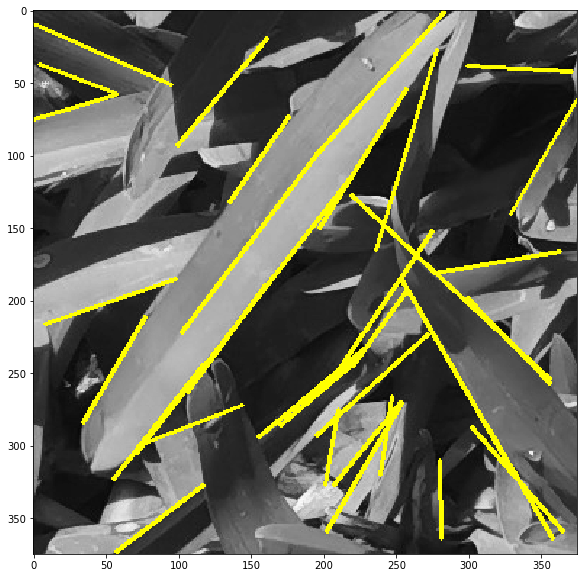

In [39]:
# Transformación de Hough

imagenfiltrada_uint8 = np.uint8(imagen_filtrada)
hough_image,lineas = hough_img(imagenfiltrada_uint8,gris_ponderado)
plt.figure(figsize = (10,10))
plt.imshow(hough_image)
cv2.imwrite('./imagenes/contour_image.jpg',hough_image)

## Cálculo de Intersección de Lineas

Teniendo una estimación de la lineas rectas que conforman la imagen, se propuso construir una malla (de lineas verticales y horizontales) de forma que al cruzarla con las lineas de Hough, se pueda determinar el número de intersecciones y, con ello, el número estimado de hojas.

Primero se realiza un barrido con lineas verticales, luego horizontales, descartando las lineas de Hough encontradas con cada intersección.


### Función para Encontrar Intersecciones
Esta función utiliza puntos correspondientes a dos lineas (4 puntos en total, 2 para definir cada linea) y se calcula si existe o no intersección entre ellas.

In [49]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    
    if div == 0:
        return 0 # Las lineas no se intersectan
    
    else:
        return 1

#### Construcción de Lineas de Hough, y Malla Vertical / Horizontal

In [52]:
lineas_hough = []
interseccion = 0
malla_vertical = []
malla_horizontal = []

# Arreglo de Lineas de Hough a partir de Puntos
for linea in lineas:
    lineas_hough.append([[linea[0][0],linea[0][1]],[linea[0][2],linea[0][3]]])

# Malla de lineas verticales
for i in range(5,hough_image.shape[0],5):
    malla_vertical.append([[i,0],[i,hough_image.shape[1]]])
    
# Malla de lineas horizontales
for i in range(5,hough_image.shape[1],5):
    malla_horizontal.append([[0,i],[hough_image.shape[0],i]])
    

### Barrido de Lineas

In [53]:
contador_intersecciones = 0
interseccion = 0

# Barrido Vertical
for indice_malla in range(np.shape(malla_vertical)[0]):
    for indice_houg in range(np.shape(lineas_hough)[0]):
        interseccion = line_intersection(malla_vertical[indice_malla], lineas_hough[indice_houg])
        if interseccion:
            lineas_hough[indice_houg] = [[0,0],[0,0]]
            contador_intersecciones +=1
            interseccion = 0

# Barrido Horizontal
for indice_malla in range(np.shape(malla_horizontal)[0]):
    for indice_houg in range(np.shape(lineas_hough)[0]):
        interseccion = line_intersection(malla_horizontal[indice_malla], lineas_hough[indice_houg])
        if interseccion:
            lineas_hough[indice_houg] = [[0,0],[0,0]]
            contador_intersecciones +=1
            interseccion = 0


### Número de Hojas en el Cuadro de Visión

In [54]:
numero_hojas = int(contador_intersecciones/2)
print("El número de hojas estimado es de:",numero_hojas)

El número de hojas estimado es de: 17


En el archivo adjunto, se encuentra el Pipeline completo, para estimación de tallos de grama de un campo de superficie especificada.